# **Data Visualization**

## Objectives
* Set the image shape.
* Analyze the average and variability of images.
* Compare differences between average images.
* Create image montages.
* Plot the number of images in the training, validation, and test sets.

## Inputs
Images are taken from the test, train, validation folders and their subfolders.

```
└───inputs/ 
    └───potato_disease_dataset/ 
        ├───test/
        │   ├───healthy
        │   ├───early_blight
        │   └───late_blight                   
        ├───train/
        │   ├───healthy
        │   ├───early_blight
        │   └───late_blight          
        └───validation/
            ├───healthy
            ├───early_blight
            └───late_blight               
```

## Outputs
- Image shape embeded in pickle file.
- Mean and variability of images per label plot.
- Comparison of average images.
- An image montage.
- Number of images in train, validation, and test set plotted.

---

## Import necessary packages for this notebook

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

---

## Change working directory

As the notebooks are within a subfolder, we will need to change the working directory when running the notebook in the editor.

We need to change the working directory from its current folder to its parent folder.
* We access the current directory with `os.getcwd()`

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/ci-ms5-spudscan/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* `os.path.dirname()` gets the parent directory
* `os.chir()` defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory.

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/ci-ms5-spudscan'

---

## Set input directory
Set train, validation and test paths.

In [5]:
my_data_dir = 'inputs/potato_disease_dataset'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

print("Train path:", train_path)
print("Validation path:", val_path)
print("Test path:", test_path)

Train path: inputs/potato_disease_dataset/train
Validation path: inputs/potato_disease_dataset/validation
Test path: inputs/potato_disease_dataset/test


---

## Set output directory

Change the version number below to change output dir.

In [6]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

---

## Set Label Names

In [7]:
import re

labels = os.listdir(train_path)
print('Labels for the images are', labels)

Labels for the images are ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


---

## Data visualization of image data

### Image Shape
In the field of computer vision, it is advisable to normalise the pixel values of images based on the mean and standard deviation of the dataset.

This normalisation process ensures consistency in results when applying models to new images and is beneficial for transfer learning. However, calculating these statistics can be challenging because the entire dataset typically cannot be loaded into memory at once. Therefore, it is necessary to iterate through the dataset in batches to compute these values accurately.

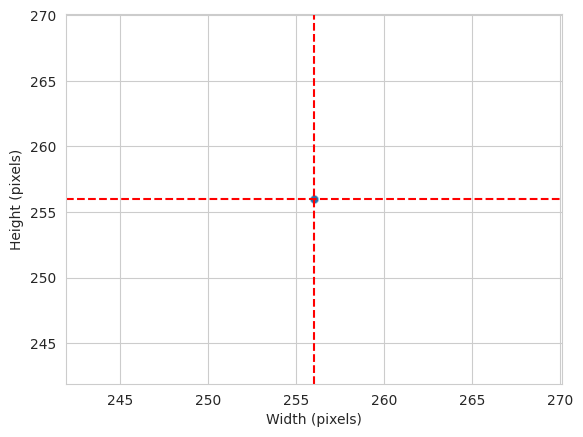

Width average: 256 
Height average: 256


In [8]:
from skimage import io

# Initialize lists to store dimensions
heights, widths = [], []

# Loop through each label (disease category)
for label in labels:
    label_path = os.path.join(train_path, label)
    for image_filename in os.listdir(label_path):
        img_path = os.path.join(label_path, image_filename)
        img = io.imread(img_path)  # Use io.imread to read the image
        height, width, _ = img.shape
        heights.append(height)  # image height
        widths.append(width)  # image width

# Plotting the dimensions
sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=widths, y=heights, alpha=0.2, ax=axes)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")

# Calculate and plot the mean dimensions
mean_height = int(np.array(heights).mean())
mean_width = int(np.array(widths).mean())
axes.axvline(x=mean_width, color='r', linestyle='--')
axes.axhline(y=mean_height, color='r', linestyle='--')
plt.show()

# Print the average dimensions
print(f"Width average: {mean_width} \nHeight average: {mean_height}")

### Set image shape

In [9]:
image_shape = (mean_width, mean_height, 3)
image_shape

(256, 256, 3)

### Save the image shape embeddings

In [10]:
joblib.dump(value=image_shape,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v2/image_shape.pkl']

---

## Average and variability of images per label

### Function to load images in an array (tensor)

In [11]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):
    x, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                x = np.append(x, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return x, y

### Load image shapes and labels in an array

In [12]:
x, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(x.shape, y.shape)

(90, 256, 256, 3) (90,)


### Plot and save mean and variability of images per label

In [24]:
def plot_mean_variability_per_labels(x, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = x[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label Potato___Early_blight ====
Image Shape: (256, 256, 3)
==== Label Potato___Late_blight ====
Image Shape: (256, 256, 3)
==== Label Potato___healthy ====
Image Shape: (256, 256, 3)


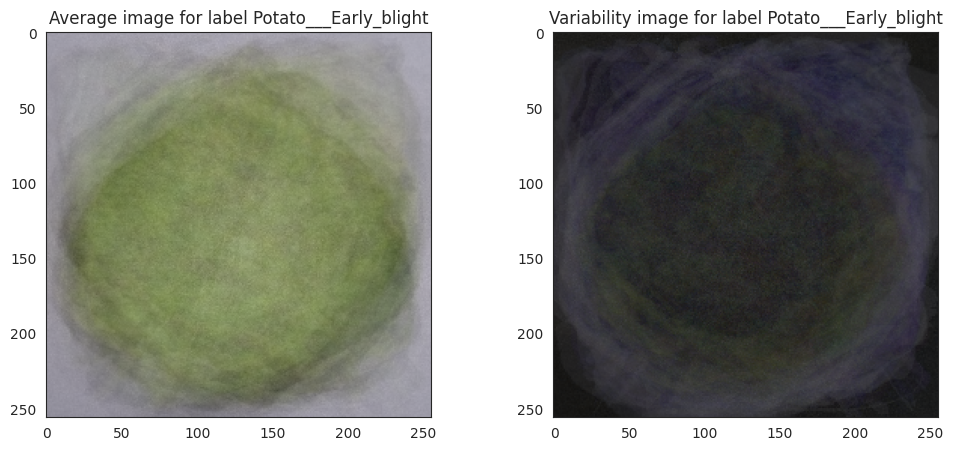

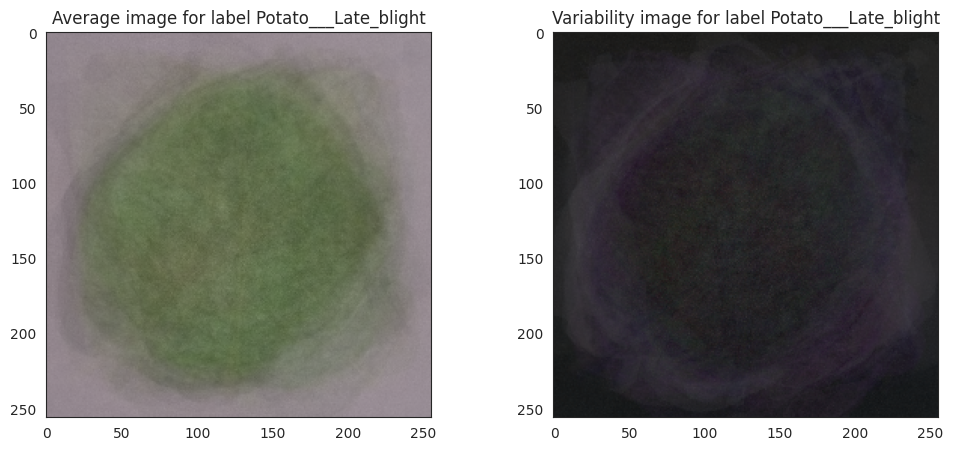

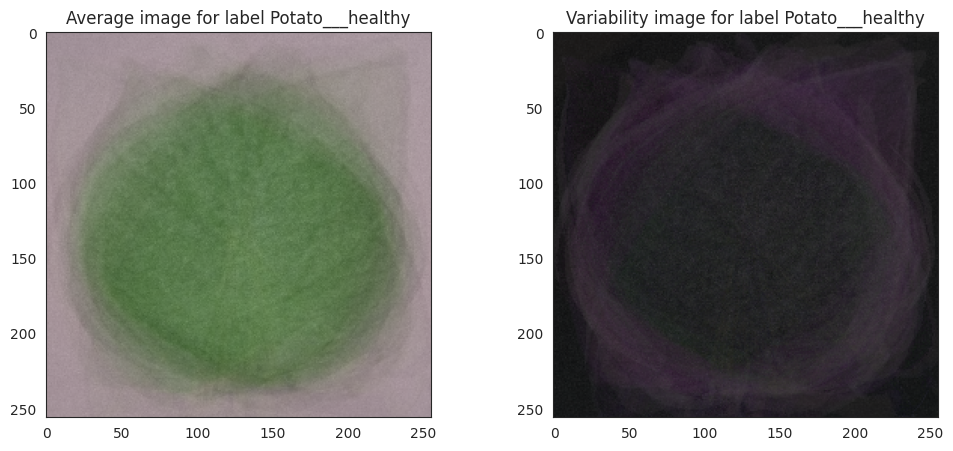

In [25]:
plot_mean_variability_per_labels(x=x, y=y, figsize=(12, 5), save_image=True)